In [31]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_columns", 100)

## Preprocessing

In [3]:
train = pd.read_csv('../train_final.csv')

In [4]:
train.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,44638.000000,44638.000000,44638.00000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000,44638.000000
mean,0.297594,99.395291,2016.15675,27.095166,15.778328,0.931516,2.507303,1.852883,0.102424,0.008289,0.034052,0.069672,0.140799,0.238026,2.149133,101.624687,0.067723,0.603253
std,0.457205,104.485734,0.70504,13.654692,8.807604,1.002021,1.928111,0.578898,0.393273,0.091649,0.181364,0.726281,1.540109,0.682989,17.134385,48.429930,0.255077,0.803659
min,0.000000,0.000000,2015.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,2016.00000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.380000,0.000000,0.000000
50%,0.000000,65.000000,2016.00000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.500000,0.000000,0.000000
75%,1.000000,154.000000,2017.00000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.00000,53.000000,31.000000,16.000000,40.000000,55.000000,3.000000,2.000000,1.000000,26.000000,72.000000,21.000000,391.000000,510.000000,8.000000,5.000000


In [5]:
# Сумма ночевок
train['total_nights'] = train['stays_in_weekend_nights'] + train['stays_in_week_nights']
# Проживание длительностью > 7 ночей
train['long_stay_flag'] = (train['total_nights'] > 7).astype(int)
# Общее кол-во гостей
train['total_guests'] = train[['adults', 'children', 'babies']].sum(axis=1)
# Плотность проживания
train['guests_per_night'] = train.apply(lambda x: x.total_guests / x.total_nights if x.total_nights > 0 else 0, axis=1)
# Кол-во запросов на гостя
train['special_requests_per_guest'] = train.apply(lambda x: x.total_of_special_requests / x.total_guests if x.total_guests > 0 else 0, axis=1)
# Имеется ли special_request
train['has_special_request'] = (train['total_of_special_requests'] > 0).astype(int)

In [6]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
train["country_encoded"] = le.fit_transform(train["country"])

train["non_refund"] = (train["deposit_type"] == "Non Refund").astype(int)
train["reservation_match"] = (train["reserved_room_type"] == train["assigned_room_type"]).astype(int)
train["is_resort"] = (train["hotel"] == "Resort Hotel").astype(int)
train["arrival_date_month"] = train["arrival_date_month"].apply(lambda m: datetime.strptime(m, "%B").month)
meal_mapping = {
    "Undefined": 0,
    "SC": 0,
    "BB": 1,
    "HB": 2,
    "FB": 3
}
train["meal_encoded"] = train["meal"].apply(lambda x: meal_mapping[x])


features_to_encode = ["market_segment", "customer_type", "distribution_channel"]
feature_to_drop = ["hotel", "arrival_date_week_number", "arrival_date_day_of_month",
                   "reserved_room_type", "assigned_room_type", "meal", "country",
                   "market_segment", "distribution_channel", "deposit_type",
                   "customer_type", "reservation_status_date"]


def encode_labels_by_cancel_ratio(df, feature):
    cats = train.groupby(feature)["is_canceled"].mean().sort_values().index.tolist()
    mapping = dict(zip(cats, list(range(len(cats)))))
    return df[feature].apply(lambda x: mapping[x])

for feature in features_to_encode:
    train[feature + "_encoded"] = encode_labels_by_cancel_ratio(train, feature)

train = train.drop(columns=feature_to_drop)

In [7]:
train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,long_stay_flag,total_guests,guests_per_night,special_requests_per_guest,has_special_request,country_encoded,non_refund,reservation_match,is_resort,meal_encoded,market_segment_encoded,customer_type_encoded,distribution_channel_encoded
0,0,3,2016,2,0,2,2,0.0,0,0,0,0,0,0,81.0,1,0,2,0,2.0,1.000000,0.00,0,121,0,0,1,1,1,3,0
1,1,50,2016,11,1,2,2,0.0,0,0,0,0,0,0,93.6,0,2,3,0,2.0,0.666667,1.00,1,12,0,1,0,1,5,3,3
2,0,14,2015,9,1,5,2,2.0,0,0,0,0,0,0,166.0,0,3,6,0,4.0,0.666667,0.75,1,71,0,1,0,1,5,2,3
3,0,18,2015,12,2,0,2,0.0,0,0,0,0,0,0,107.0,0,0,2,0,2.0,1.000000,0.00,0,46,0,1,0,1,5,3,3
4,1,263,2016,9,2,4,2,0.0,0,0,0,0,0,0,100.3,0,0,6,0,2.0,0.333333,0.00,0,38,0,1,0,1,5,3,3


In [8]:
X = train.drop(columns=["is_canceled"])
y = train["is_canceled"]

## Modelling

In [9]:
RANDOM_SEED = 47

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

I decided to apply standard scaler to the dataset as I need to scale all features 

In [11]:
standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train)
X_valid_standardized = standard_scaler.transform(X_valid)

In [15]:
param_grid = {
    'C': [0.01, 0.1, 100],         # Сила регуляризации
    'penalty': ['l1', 'l2'],                     # Тип регуляризации
    'solver': ['liblinear', 'lbfgs'],            # Алгоритмы оптимизации
    'max_iter': [50, 100, 500]                   # Количество итераций
}

# Создаем модель
model = LogisticRegression()

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Перебор параметров
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train_standardized, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность на обучающей выборке:", grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/tuzhbagrigoriy/reps/My_mini_apps/env_test/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tuzhbagrigoriy/reps/My_mini_apps/env_test/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Лучшие параметры: {'C': 100, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая точность на обучающей выборке: 0.8287313141968666


In [16]:
# Предсказание на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid_standardized)

print("Точность на тестовой выборке:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Точность на тестовой выборке: 0.8276209677419355
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6246
           1       0.83      0.54      0.65      2682

    accuracy                           0.83      8928
   macro avg       0.83      0.75      0.77      8928
weighted avg       0.83      0.83      0.82      8928



In [26]:
y_proba = best_model.predict_proba(X_valid_standardized)[:, 1] 

In [29]:
thresholds = np.linspace(0, 1, 100)
accuracies = []

for threshold in thresholds:
    y_pred_threshold = (y_proba >= threshold).astype(int)
    acc = accuracy_score(y_valid, y_pred_threshold)
    accuracies.append(acc)

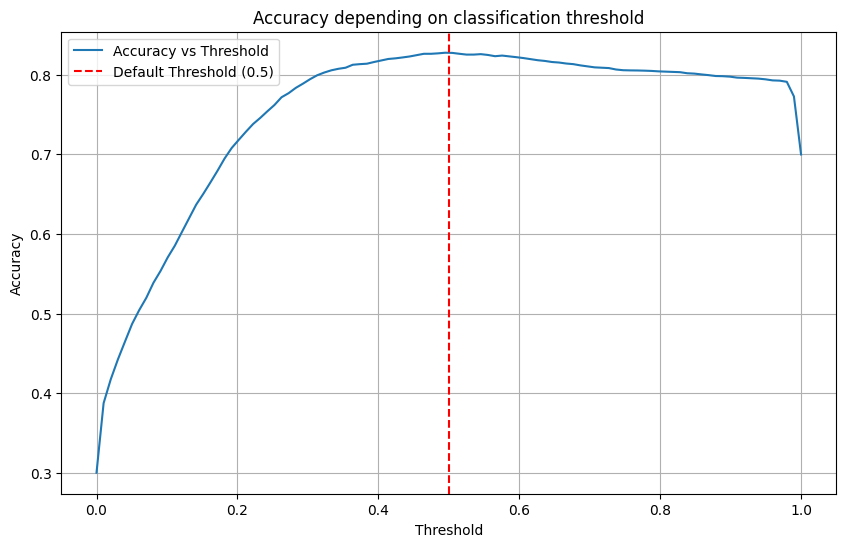

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy vs Threshold')
plt.axvline(x=0.5, color='r', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on classification threshold')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

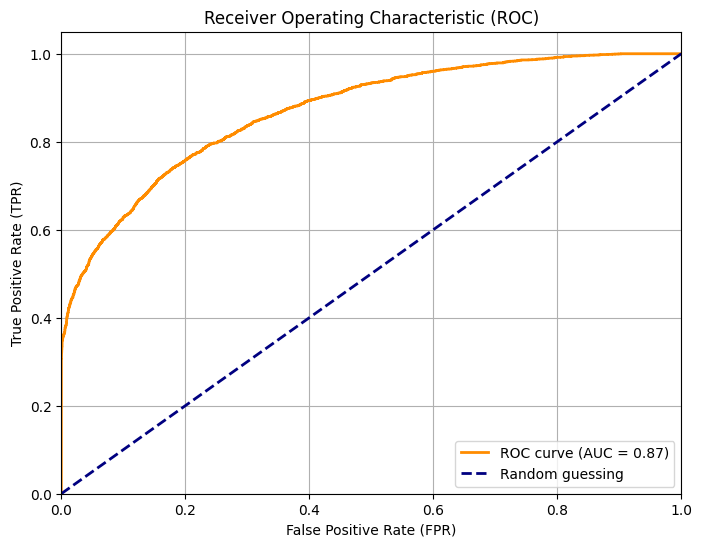

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()